In [50]:
# tensorflow utility
!pip install -q tensorflow_io==0.21.0
!pip install -q tensorflow_probability==0.14.1
!pip install -q tensorflow_addons==0.15.0

# audio classification models
!pip install -q audio_classification_models

# weights & biases
!pip install -qU wandb

ERROR: Ignored the following versions that require a different python version: 0.23.0 Requires-Python >=3.6, <3.10
ERROR: Could not find a version that satisfies the requirement tensorflow_io==0.21.0 (from versions: 0.23.1, 0.24.0, 0.25.0, 0.26.0, 0.27.0, 0.28.0, 0.29.0, 0.30.0, 0.31.0, 0.32.0, 0.33.0, 0.34.0, 0.35.0)
ERROR: No matching distribution found for tensorflow_io==0.21.0
ERROR: Could not find a version that satisfies the requirement tensorflow_addons==0.15.0 (from versions: 0.16.1, 0.17.0, 0.17.1, 0.18.0, 0.19.0, 0.20.0, 0.21.0, 0.22.0, 0.23.0)
ERROR: No matching distribution found for tensorflow_addons==0.15.0


In [2]:
import pandas as pd
import numpy as np
import random
import os
import shutil

import cv2
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'DejaVu Sans'
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

import tensorflow as tf, re, math
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import tensorflow_io as tfio
import tensorflow_addons as tfa
import tensorflow_probability as tfp

import yaml
from IPython import display as ipd
import json
from datetime import datetime

from glob import glob
from tqdm.notebook import tqdm
from kaggle_datasets import KaggleDatasets
import sklearn
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from IPython import display as ipd

import itertools
import scipy
import warnings

# Show less log messages
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

# Set true to show less logging messages
os.environ["WANDB_SILENT"] = "true"
import wandb

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


AttributeError: module 'tensorflow.python.framework.type_spec' has no attribute '_NAME_TO_TYPE_SPEC'

In [3]:
class CFG:
    wandb = True
    project = "fake-speech-detection"
    debug = False
    exp_name = "v0"
    comment = "Conformer-128x80-cosine-no_aug-no_fc"

    # Use verbose=0 for silent, 1 for interactive
    verbose = 0
    display_plot = True

    # Device for training
    device = None  # device is automatically selected

    # Model & Backbone
    model_name = "Conformer"

    # Seeding for reproducibility
    seed = 101

    # Audio params
    sample_rate = 16000
    duration = 3.5 # duration in second
    audio_len = int(sample_rate * duration)
    normalize = True

    # Spectrogram params
    spec_freq = 128 # freq axis
    n_fft = 2048
    spec_time = 256 # time axis
    hop_len = audio_len//(spec_time - 1) # non-overlap region
    fmin = 20
    fmax = sample_rate//2 # max frequency
    spec_shape = [spec_time, spec_freq] # output spectrogram shape
    
    # Audio Augmentation
    timeshift_prob = 0.0
    gn_prob = 0.0
    
    # Spectrogram Augmentation
    time_mask = 20
    freq_mask = 10
    cutmix_prob = 0.0
    cutmix_alpha = 2.5
    mixup_prob = 0.0
    mixup_alpha = 2.5

    # Batch Size & Epochs
    batch_size = 32
    drop_remainder = False
    epochs = 12
    steps_per_execution = None

    # Loss & Optimizer & LR Scheduler
    loss = "binary_crossentropy"
    optimizer = "Adam"
    lr = 1e-4
    lr_schedule = "cosine"

    # Augmentation
    augment = False

    # Clip values to [0, 1]
    clip = False

In [4]:
def seeding(SEED):
    """
    Sets all random seeds for the program (Python, NumPy, and TensorFlow).
    """
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
#     os.environ["TF_CUDNN_DETERMINISTIC"] = str(SEED)
    tf.random.set_seed(SEED)
    print("seeding done!!!")


seeding(CFG.seed)

seeding done!!!


In [6]:
def configure_device():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()  # connect to tpu cluster
        strategy = tf.distribute.TPUStrategy(tpu) # get strategy for tpu
        print('> Running on TPU ', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device='TPU'
    except: # otherwise detect GPUs
        tpu = None
        gpus = tf.config.list_logical_devices('GPU') # get logical gpus
        ngpu = len(gpus)
        if ngpu: # if number of GPUs are 0 then CPU
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy() # connect to single gpu or cpu
            device='CPU'
    return strategy, device, tpu

In [7]:
strategy, CFG.device, tpu = configure_device()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

> Running on GPU | Num of GPUs:  1
REPLICAS: 1


In [8]:
BASE_PATH = '../input/asvpoof-2019-dataset/LA/LA'

# Train 
train_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt',
                       sep=" ", header=None)
train_df.columns =['speaker_id','filename','system_id','null','class_name']
train_df.drop(columns=['null'],inplace=True)
train_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_train/flac/'+train_df.filename+'.flac'
train_df['target'] = (train_df.class_name=='spoof').astype('int32') # set labels 1 for fake and 0 for real
if True:
    train_df = train_df.groupby(['target']).sample(2500).reset_index(drop=True)
print(f'Train Samples: {len(train_df)}')
train_df.head(5)

Train Samples: 5000


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0079,LA_T_6200206,-,bonafide,../input/asvpoof-2019-dataset/LA/LA/ASVspoof20...,0
1,LA_0085,LA_T_6638771,-,bonafide,../input/asvpoof-2019-dataset/LA/LA/ASVspoof20...,0
2,LA_0098,LA_T_1236840,-,bonafide,../input/asvpoof-2019-dataset/LA/LA/ASVspoof20...,0
3,LA_0079,LA_T_6492747,-,bonafide,../input/asvpoof-2019-dataset/LA/LA/ASVspoof20...,0
4,LA_0095,LA_T_6999716,-,bonafide,../input/asvpoof-2019-dataset/LA/LA/ASVspoof20...,0


In [9]:
import re
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [28]:
from kaggle_datasets import KaggleDatasets

In [29]:
GCS_PATH = KaggleDatasets().get_gcs_path('asvspoof-2019-tfrecord-dataset')
TRAIN_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/asvspoof/train*.tfrec')
VALID_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/asvspoof/valid*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/asvspoof/test*.tfrec')

print('# NUM TRAIN: {:,}'.format(count_data_items(TRAIN_FILENAMES)))
print('# NUM VALID: {:,}'.format(count_data_items(VALID_FILENAMES)))
print('# NUM TEST: {:,}'.format(count_data_items(TEST_FILENAMES)))

# NUM TRAIN: 5,000
# NUM VALID: 4,000
# NUM TEST: 4,000


## Utility

In [30]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)


def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

In [31]:
# Trim Audio to ignore silent part in the start and end
def TrimAudio(audio, epsilon=0.15):
    pos  = tfio.audio.trim(audio, axis=0, epsilon=epsilon)
    audio = audio[pos[0]:pos[1]]
    return audio

# Crop or Pad audio to keep a fixed length
def CropOrPad(audio, target_len, pad_mode='constant'):
    audio_len = tf.shape(audio)[0]
    if audio_len < target_len: # if audio_len is smaller than target_len then use Padding
        diff_len = (target_len - audio_len)
        pad1 = random_int([], minval=0, maxval=diff_len) # select random location for padding
        pad2 = diff_len - pad1
        pad_len = [pad1, pad2]
        audio = tf.pad(audio, paddings=[pad_len], mode=pad_mode) # apply padding
    elif audio_len > target_len:  # if audio_len is larger than target_len then use Cropping
        diff_len = (audio_len - target_len)
        idx = tf.random.uniform([], 0, diff_len, dtype=tf.int32) # select random location for cropping
        audio = audio[idx: (idx + target_len)]
    audio = tf.reshape(audio, [target_len])
    return audio

# Randomly shift audio -> any sound at <t> time may get shifted to <t+shift> time
def TimeShift(audio, prob=0.5):
    if random_float() < prob:
        shift = random_int(shape=[], minval=0, maxval=tf.shape(audio)[0])
        if random_float() < 0.5:
            shift = -shift
        audio = tf.roll(audio, shift, axis=0)
    return audio

# Apply random noise to audio data
def GaussianNoise(audio, std=[0.0025, 0.025], prob=0.5):
    std = random_float([], std[0], std[1])
    if random_float() < prob:
        GN = tf.keras.layers.GaussianNoise(stddev=std)
        audio = GN(audio, training=True) # training=False don't apply noise to data
    return audio

# Applies augmentation to Audio Signal
def AudioAug(audio):
    audio = TimeShift(audio, prob=CFG.timeshift_prob)
    audio = GaussianNoise(audio, prob=CFG.gn_prob)
    return audio

def Normalize(data):
    MEAN = tf.math.reduce_mean(data)
    STD = tf.math.reduce_std(data)
    data = tf.math.divide_no_nan(data - MEAN, STD)
    return data

In [32]:
# Randomly mask data in time and freq axis
def TimeFreqMask(spec, time_mask, freq_mask, prob=0.5):
    if random_float() < prob:
        spec = tfio.audio.freq_mask(spec, param=freq_mask)
        spec = tfio.audio.time_mask(spec, param=time_mask)
    return spec

# Applies augmentation to Spectrogram
def SpecAug(spec):
    spec = TimeFreqMask(spec, time_mask=CFG.time_mask, freq_mask=CFG.freq_mask, prob=0.5)
    return spec

# Compute MixUp Augmentation for Spectrogram
def get_mixup(alpha=0.2, prob=0.5):
    """Apply Spectrogram-MixUp augmentaiton. Apply Mixup to one batch and its shifted version"""
    def mixup(specs, labels, alpha=alpha, prob=prob):
        if random_float() > prob:
            return specs, labels

        spec_shape = tf.shape(specs)
        label_shape = tf.shape(labels)

        beta = tfp.distributions.Beta(alpha, alpha) # select lambda from beta distribution
        lam = beta.sample(1)[0]
        
        # It's faster to roll the batch by one instead of shuffling it to create image pairs
        specs = lam * specs + (1 - lam) * tf.roll(specs, shift=1, axis=0) # mixup = [1, 2, 3]*lam + [3, 1, 2]*(1 - lam)
        labels = lam * labels + (1 - lam) * tf.roll(labels, shift=1, axis=0)

        specs = tf.reshape(specs, spec_shape)
        labels = tf.reshape(labels, label_shape)
        return specs, labels
    return mixup


def get_cutmix(alpha, prob=0.5):
    """Apply Spectrogram-CutMix augmentaiton which only cuts patch across time axis unline 
    typical Computer-Vision CutMix. Apply CutMix to one batch and its shifted version.
    """
    def cutmix(specs, labels, alpha=alpha, prob=prob):
        if random_float() > prob:
            return specs, labels
        spec_shape = tf.shape(specs)
        label_shape = tf.shape(labels)
        W = tf.cast(spec_shape[1], tf.int32)  # [batch, time, freq, channel]

        # Lambda from beta distribution
        beta = tfp.distributions.Beta(alpha, alpha)
        lam = beta.sample(1)[0]
        
        # It's faster to roll the batch by one instead of shuffling it to create image pairs
        specs_rolled = tf.roll(specs, shift=1, axis=0) # specs->[1, 2, 3], specs_rolled->[3, 1, 2]
        labels_rolled = tf.roll(labels, shift=1, axis=0)

        # Select random patch size
        r_x = random_int([], minval=0, maxval=W)
        r = 0.5 * tf.math.sqrt(1.0 - lam)
        r_w_half = tf.cast(r * tf.cast(W, tf.float32), tf.int32)

        # Select random location in time axis
        x1 = tf.cast(tf.clip_by_value(r_x - r_w_half, 0, W), tf.int32)
        x2 = tf.cast(tf.clip_by_value(r_x + r_w_half, 0, W), tf.int32)

        # outer-pad patch -> [0, 0, x, x, 0, 0]
        patch1 = specs[:, x1:x2, :, :]  # [batch, time, freq, channel]
        patch1 = tf.pad(
            patch1, [[0, 0], [x1, W - x2], [0, 0], [0, 0]])  # outer-pad

        # inner-pad-patch -> [y, y, 0, 0, y, y]
        patch2 = specs_rolled[:, x1:x2, :, :]  # [batch, mel, time, channel]
        patch2 = tf.pad(
            patch2, [[0, 0], [x1, W - x2], [0, 0], [0, 0]])  # outer-pad
        patch2 = specs_rolled - patch2  # inner-pad-patch = img - outer-pad-patch
        
        # patch1 -> [0, 0, x, x, 0, 0], patch2 -> [y, y, 0, 0, y, y]
        # cutmix = (patch1 + patch2) -> [y, y, x, x, y, y]
        specs = patch1 + patch2  # cutmix img

        # Compute lambda = [1 - (patch_area/image_area)]
        lam = tf.cast((1.0 - (x2 - x1) / (W)),tf.float32)  # no H term as (y1 - y2) = H
        labels = lam * labels + (1.0 - lam) * labels_rolled  # cutmix label

        specs = tf.reshape(specs, spec_shape)
        labels = tf.reshape(labels, label_shape)

        return specs, labels
    return cutmix

In [33]:
# Compute Spectrogram from audio
def Audio2Spec(audio,spec_shape=[256, 128],sr=16000,nfft=2048,window=2048,fmin=20,fmax=8000):
    spec_time = spec_shape[0]
    spec_freq = spec_shape[1]
    audio_len = tf.shape(audio)[0]
    hop_length = tf.cast((audio_len // (spec_time - 1)), tf.int32) # compute hop_length to keep desired spec_shape
    spec = tfio.audio.spectrogram(audio, nfft=nfft, window=window, stride=hop_length) # convert to spectrogram
    mel_spec = tfio.audio.melscale(spec, rate=sr, mels=spec_freq, fmin=fmin, fmax=fmax) # transform to melscale
    db_mel_spec = tfio.audio.dbscale(mel_spec, top_db=80) # from power to db (log10) scale
    if tf.shape(db_mel_spec)[0] > spec_time:  # check if we have desiered shape
        db_mel_spec = db_mel_spec[:spec_time,:]
    db_mel_spec = tf.reshape(db_mel_spec, spec_shape)
    return db_mel_spec

# Convert spectrogram (H,W) to image (H,W,1)
def Spec2Img(spec, num_channels=1):
    # 1 channel image
    img = spec[..., tf.newaxis]
    # Copy same image across channel axis
    if num_channels>1:
        img = tf.tile(img, [1, 1, num_channels])
    return img

# 9. Data Pipeline 🍚

In [34]:
# Decode audio from wav
def decode_audio(data, audio_len):
    # Decode
    audio, sr = tf.audio.decode_wav(data)
    audio = tf.reshape(audio, [audio_len]) # explicit size needed for TPU
    audio = tf.cast(audio,tf.float32)
    # Normalization
    if CFG.normalize:
        audio = Normalize(audio)
    return audio

# Decode label
def decode_label(label):
    label = tf.cast(label, tf.float32)
    return label
    
# Read tfrecord data & parse it & do augmentation
def read_tfrecord(example, augment=True, return_id=False, return_label=True, target_len=CFG.audio_len, spec_shape=CFG.spec_shape):
    tfrec_format = {
        "audio" : tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id" : tf.io.FixedLenFeature([], tf.string),
        "speaker_id": tf.io.FixedLenFeature([], tf.string),
        "system_id" : tf.io.FixedLenFeature([], tf.string),
        "audio_len" : tf.io.FixedLenFeature([], tf.int64),
        "target" : tf.io.FixedLenFeature([], tf.int64),
    }
    # Parses a single example proto.
    example = tf.io.parse_single_example(
        example, tfrec_format
    )
    # Extract data from example proto
    audio_id = example["id"]
    audio_len = example["audio_len"]
    # Decoding
    audio = decode_audio(example["audio"], audio_len)  # decode audio from .wav
    target = decode_label(example["target"]) # decode label -> type cast
    # Trim Audio
    audio = TrimAudio(audio)
    # Crop or Pad audio to keep a fixed length
    audio = CropOrPad(audio, target_len)
    if augment:
        # Apply AudioAug
        audio = AudioAug(audio)
    # Compute Spectrogram
    spec = Audio2Spec(audio, spec_shape=spec_shape)
    if augment:
        # Apply SpecAug
        spec = SpecAug(spec)
    # Spectrogram (H, W) to Image (H, W, C)
    img = Spec2Img(spec, num_channels=1) 
    # Clip & Reshape
    img = tf.clip_by_value(img, 0, 1) if CFG.clip else img
    img = tf.reshape(img, [*spec_shape, 1])
    
    if not return_id:
        if return_label:
            return (img, target)
        else:
            return img
    else:
        if return_label:
            return (img, target, audio_id)
        else:
            return (img, audio_id)

In [36]:
def get_dataset(
    filenames,
    shuffle=True,
    repeat=True,
    augment=True,
    cache=True,
    return_id=False,
    return_label=True,
    batch_size=CFG.batch_size * REPLICAS,
    target_len=CFG.audio_len,
    spec_shape=CFG.spec_shape,
    drop_remainder=False,
    seed=CFG.seed,
):
    # Real tfrecord files
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) 
    if cache:
        dataset = dataset.cache()  # cache data for speedup
    if repeat:
        dataset = dataset.repeat()  # repeat the data (for training only)
    if shuffle:
        dataset = dataset.shuffle(1024, seed=seed)  # shuffle the data (for training only)
        options = tf.data.Options()
        options.experimental_deterministic = False  # order won't be maintained when we shuffle
        dataset = dataset.with_options(options)
    # Parse data from tfrecord
    dataset = dataset.map(lambda x: read_tfrecord(x,
                                                  augment=augment,
                                                  return_id=return_id,
                                                  return_label=return_label,
                                                  target_len=target_len,),
                          num_parallel_calls=AUTO,)
    # Batch Data Samples
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    # MixUp
    if CFG.mixup_prob and augment and return_label:
        dataset = dataset.map(get_mixup(alpha=CFG.mixup_alpha,prob=CFG.mixup_prob),num_parallel_calls=AUTO)
    # CutMix
    if CFG.cutmix_prob and augment and return_label:
        dataset = dataset.map(get_cutmix(alpha=CFG.cutmix_alpha,prob=CFG.cutmix_prob),num_parallel_calls=AUTO)
    # Prefatch data for speedup
    dataset = dataset.prefetch(AUTO)
    return dataset

In [37]:
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          save = False):
    """Plot Confusion Matrix"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    return
    
def plot_history(history):
    """Plot model training history"""
    plt.figure(figsize=(15, 5))
    plt.plot(
        np.arange(len(history["f1_score"])),
        history["f1_score"],
        "-o",
        label="Train f1_score",
        color="#ff7f0e",
    )
    plt.plot(
        np.arange(len(history["f1_score"])),
        history["val_f1_score"],
        "-o",
        label="Val f1_score",
        color="#1f77b4",
    )
    x = np.argmax(history["val_f1_score"])
    y = np.max(history["val_f1_score"])
    xdist = plt.xlim()[1] - plt.xlim()[0]
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x, y, s=200, color="#1f77b4")
    plt.text(x - 0.03 * xdist, y - 0.13 * ydist, "max f1_score\n%.2f" % y, size=14)
    plt.ylabel("f1_score", size=14)
    plt.xlabel("Epoch", size=14)
    plt.legend(loc=2)
    plt2 = plt.gca().twinx()
    plt2.plot(
        np.arange(len(history["f1_score"])),
        history["loss"],
        "-o",
        label="Train Loss",
        color="#2ca02c",
    )
    plt2.plot(
        np.arange(len(history["f1_score"])),
        history["val_loss"],
        "-o",
        label="Val Loss",
        color="#d62728",
    )
    x = np.argmin(history["val_loss"])
    y = np.min(history["val_loss"])
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x, y, s=200, color="#d62728")
    plt.text(x - 0.03 * xdist, y + 0.05 * ydist, "min loss", size=14)
    plt.ylabel("Loss", size=14)
    plt.legend(loc=3)
    plt.savefig(f"history_plot.png")
    plt.show()
    return

def display_batch(batch, row=2, col=5):
    "Plot one batch data"
    imgs, tars = batch
    plt.figure(figsize=(5.0*col, 3.5*row))
    for idx in range(row*col):
        img = imgs[idx].numpy().transpose()[0]
        tar = tars[idx].numpy()
        plt.subplot(row, col, idx+1)
        plt.imshow(img, cmap='coolwarm')
        text = 'Fake' if tar else 'Real'
        plt.title(text, fontsize=15, color=('red' if tar else 'green'))
    plt.tight_layout();
    plt.grid(False)
    plt.show();
    return

## Without Augmentation

image_shape: (20, 256, 128, 1) target_shape:(20,)
image_dtype: <dtype: 'float32'> target_dtype:<dtype: 'float32'>


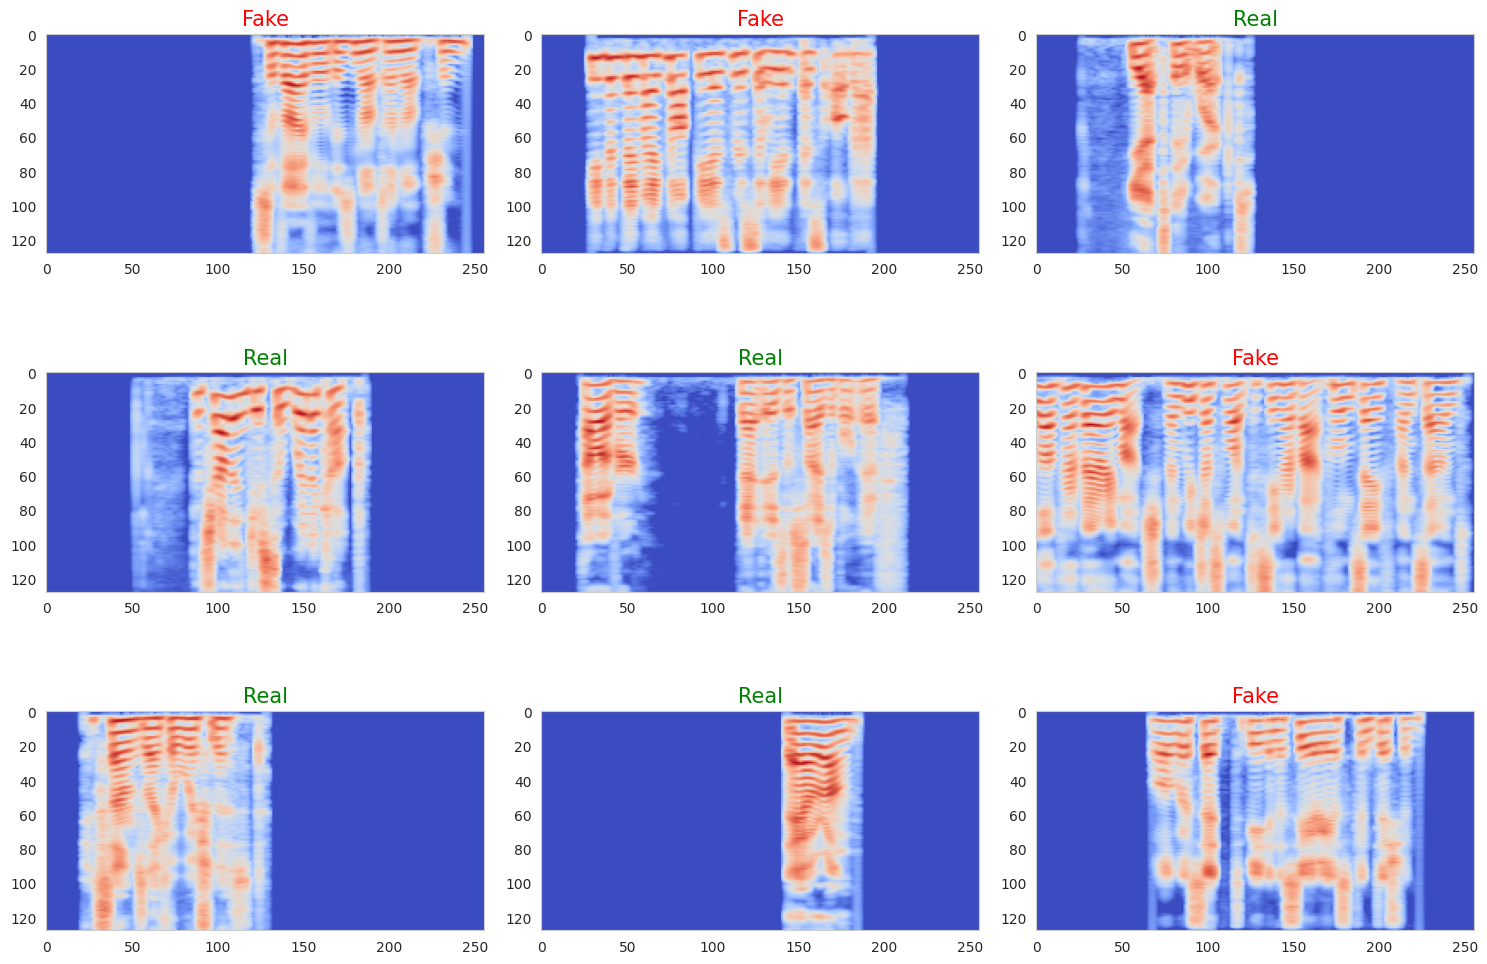

In [38]:
ds = get_dataset(TRAIN_FILENAMES[:2], augment=False, cache=False, repeat=False).take(1)
batch = next(iter(ds.unbatch().batch(20)))
imgs, tars = batch
print(f'image_shape: {imgs.shape} target_shape:{tars.shape}')
print(f'image_dtype: {imgs.dtype} target_dtype:{tars.dtype}')
display_batch(batch, row=3, col=3)

## With Augmentation

image_shape: (20, 256, 128, 1) target_shape:(20,)
image_dtype: <dtype: 'float32'> target_dtype:<dtype: 'float32'>


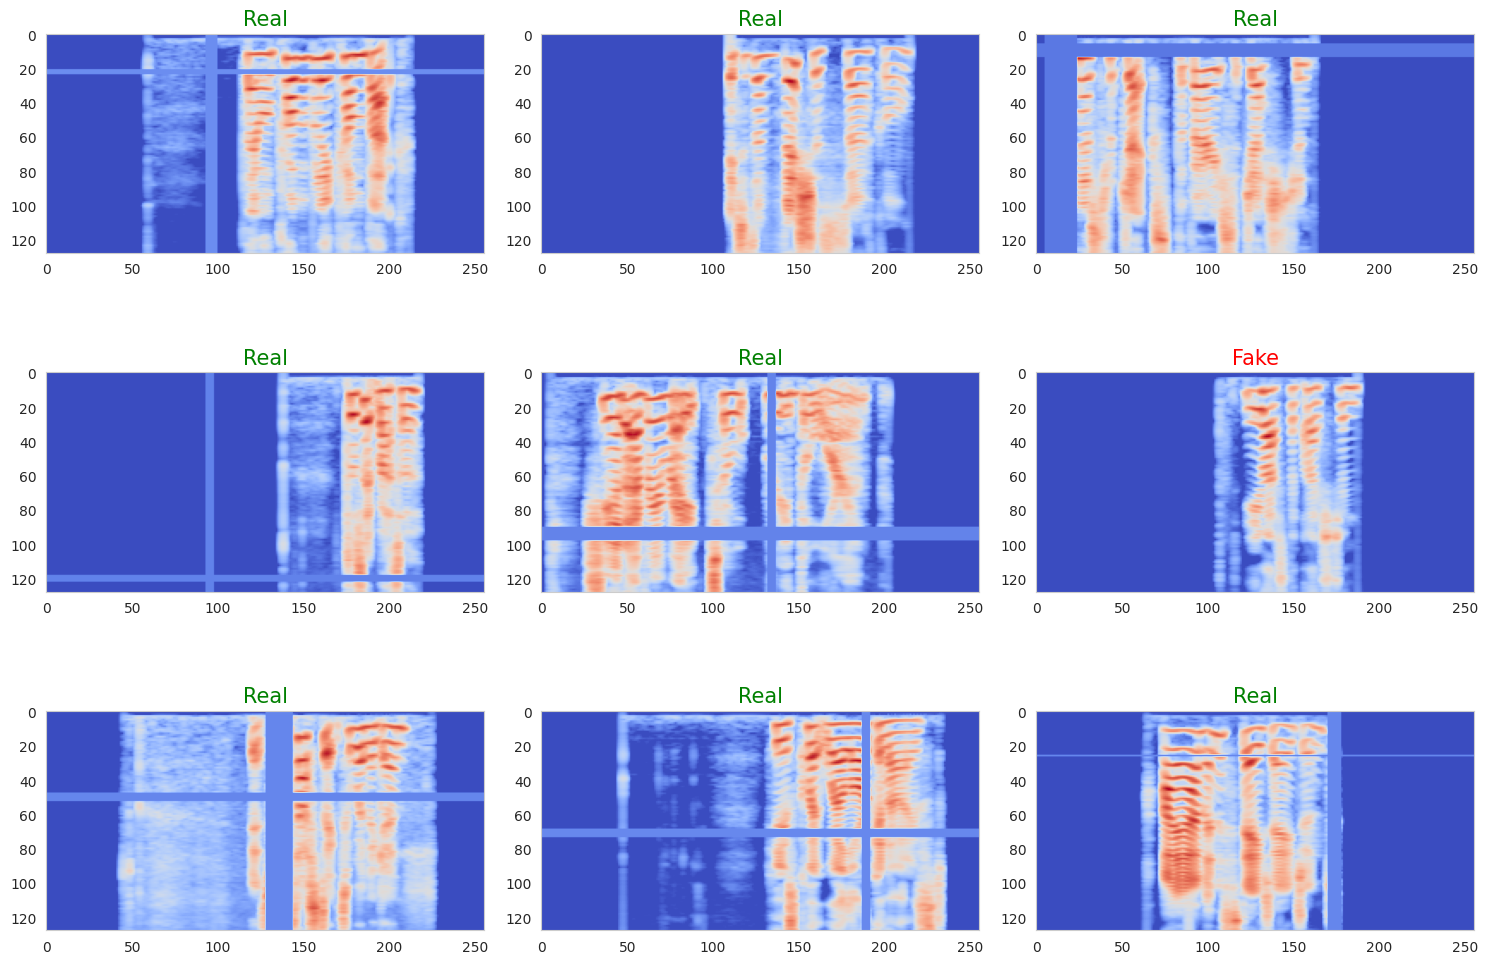

In [39]:
ds = get_dataset(TRAIN_FILENAMES[:2], augment=True, cache=False, repeat=False).take(1)
batch = next(iter(ds.unbatch().batch(20)))
imgs, tars = batch
print(f'image_shape: {imgs.shape} target_shape:{tars.shape}')
print(f'image_dtype: {imgs.dtype} target_dtype:{tars.dtype}')
display_batch(batch, row=3, col=3)

In [40]:
def get_metrics():
    acc = tf.keras.metrics.BinaryAccuracy()
    f1_score = tfa.metrics.F1Score(num_classes=1, threshold=0.5, average='macro')
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    return [acc, precision, recall, f1_score]

In [41]:
import math

def get_lr_callback(mode='exp', batch_size=64, epochs=30, plot=False):
    """adapted from @cdeotte"""
    lr_start = 5e-5
    lr = 0.001 # base_lr
    lr_max = 5e-4 # max lr - will be multiplied by batch_size
    lr_min = 0.1e-4 # min lr
    lr_ramp_ep = 4 # warming up epochs
    lr_sus_ep = 0 # sustain epochs lr after warming up
    lr_decay = 0.8 # decay rate

    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max

        elif mode == 'exp':
            lr = (lr_max - lr_min) * lr_decay**(epoch - \
                  lr_ramp_ep - lr_sus_ep) + lr_min

        elif mode == 'step':
            lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)

        elif mode == 'cosine':
            decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            cosine_decay = 0.5 * (1 + math.cos(phase))
            lr = (lr_max - lr_min) * cosine_decay + lr_min
        return lr

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(
            np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch')
        plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=0)

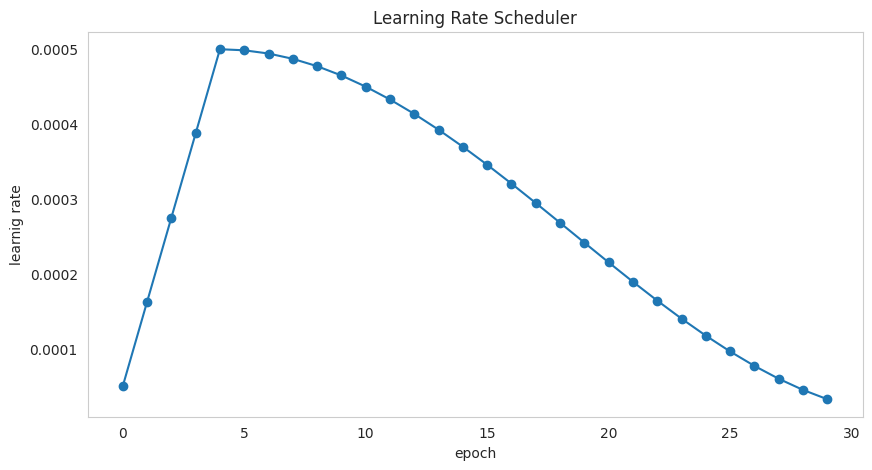

In [42]:
lr_callback = get_lr_callback(mode=CFG.lr_schedule,epochs=30,plot=True)

In [43]:
import audio_classification_models as acm

URL = 'https://github.com/awsaf49/audio_classification_models/releases/download/v1.0.8/conformer-encoder.h5'

def Conformer(input_shape=(128, 80, 1),num_classes=1, final_activation='sigmoid', pretrain=True):
    """Souce Code: https://github.com/awsaf49/audio_classification_models"""
    inp = tf.keras.layers.Input(shape=input_shape)
    backbone = acm.ConformerEncoder()
    out = backbone(inp)
    if pretrain:
        acm.utils.weights.load_pretrain(backbone, url=URL)
    out = tf.keras.layers.GlobalAveragePooling1D()(out)
#     out = tf.keras.layers.Dense(32, activation='selu')(out)
    out = tf.keras.layers.Dense(num_classes, activation=final_activation)(out)
    model = tf.keras.models.Model(inp, out)
    return model

In [44]:
def get_model(name=CFG.model_name, loss=CFG.loss,):
    model = Conformer(input_shape=[*CFG.spec_shape,1],pretrain=True)
    lr = CFG.lr
    if CFG.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    elif CFG.optimizer == "AdamW":
        opt = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=lr)
    elif CFG.optimizer == "RectifiedAdam":
        opt = tfa.optimizers.RectifiedAdam(learning_rate=lr)
    else:
        raise ValueError("Wrong Optimzer Name")
    model.compile(
        optimizer=opt,
        loss=loss,
        steps_per_execution=CFG.steps_per_execution, # to reduce idle time
        metrics=get_metrics()
    )
    return model

In [45]:
model = get_model()
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


35530456/35530456 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 128, 1)]     0         
                                                                 
 conformer_encoder (Conform  (None, None, 144)         8959680   
 erEncoder)                                                      
                                                                 
 global_average_pooling1d (  (None, 144)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 145       
                                                                 
Total params: 8959825 (34.18 MB)
Trainable params: 8955217 (34.16 MB)
Non-trainable params: 4608 (18.00 KB)
____________________

In [55]:
import wandb

In [56]:
if CFG.wandb:
    "login in wandb otherwise run anonymously"
    try:
        # Addo-ons > Secrets > WANDB
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        api_key = user_secrets.get_secret("WANDB")
        wandb.login(key=api_key)
        anonymous = None
    except:
        anonymous = "must"


def wandb_init():
    "initialize project on wandb"
    id_ = wandb.util.generate_id() # generate random id
    config = {k: v for k, v in dict(vars(CFG)).items() if "__" not in k} # convert class to dict
    config["id"] = id_
    run = wandb.init(
        id=id_,
        project="fake-speech-detection",
        name=f"dim-{CFG.spec_shape[0]}x{CFG.spec_shape[1]}|model-{CFG.model_name}",
        config=config,
        anonymous=anonymous,
        group=CFG.comment,
        reinit=True,
        resume="allow",
    )
    return run

In [ ]:
# Initialize wandb Run
if CFG.wandb:
    run = wandb_init()
    WandbCallback = wandb.keras.WandbCallback(save_model=False)
    
# Load gcs_path of train, valid & test
TRAIN_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/asvspoof/train*.tfrec')
VALID_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/asvspoof/valid*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/asvspoof/test*.tfrec')

# Take Only 10 Files if run in Debug Mode
if CFG.debug:
    TRAIN_FILENAMES = TRAIN_FILENAMES[:2]
    VALID_FILENAMES = VALID_FILENAMES[:2]
    TEST_FILENAMES = TEST_FILENAMES[:2]

# Shuffle train files
random.shuffle(TRAIN_FILENAMES)

# Count train and valid samples
NUM_TRAIN = count_data_items(TRAIN_FILENAMES)
NUM_VALID = count_data_items(VALID_FILENAMES)
NUM_TEST = count_data_items(TEST_FILENAMES)

# Compute batch size & steps_per_epoch
BATCH_SIZE = CFG.batch_size * REPLICAS
STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE

print("#" * 60)
print("#### IMAGE_SIZE: (%i, %i) | BATCH_SIZE: %i | EPOCHS: %i"% (CFG.spec_shape[0],
                                                                  CFG.spec_shape[1],
                                                                  BATCH_SIZE,
                                                                  CFG.epochs))
print("#### MODEL: %s | LOSS: %s"% (CFG.model_name, CFG.loss))
print("#### NUM_TRAIN: {:,} | NUM_VALID: {:,}".format(NUM_TRAIN, NUM_VALID))
print("#" * 60)

# Log in w&B before training
if CFG.wandb:
    wandb.log(
        {
            "num_train": NUM_TRAIN,
            "num_valid": NUM_VALID,
            "num_test": NUM_TEST,
        }
    )

# Build model in device
K.clear_session()
with strategy.scope():
    model = get_model(name=CFG.model_name,loss=CFG.loss)

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/ckpt.h5",
    verbose=CFG.verbose,
    monitor="val_f1_score",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
)
callbacks = [checkpoint, get_lr_callback(mode=CFG.lr_schedule,epochs=CFG.epochs)]

if CFG.wandb:
    # Include w&b callback if WANDB is True
    callbacks.append(WandbCallback)

# Create train & valid dataset
train_ds = get_dataset(
    TRAIN_FILENAMES,
    augment=CFG.augment,
    batch_size=BATCH_SIZE,
    cache=False,
    drop_remainder=False,
)
valid_ds = get_dataset(
    VALID_FILENAMES,
    shuffle=False,
    augment=False,
    repeat=False,
    batch_size=BATCH_SIZE,
    cache=False,
    drop_remainder=False,
)

# Train model
history = model.fit(
    train_ds,
    epochs=CFG.epochs if not CFG.debug else 2,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks,
    validation_data=valid_ds,
    #         validation_steps = NUM_VALID/BATCH_SIZE,
    verbose=CFG.verbose,
)

# Convert dict history to df history
history = pd.DataFrame(history.history)

# Load best weights
model.load_weights("/kaggle/working/ckpt.h5")

# Plot Training History
if CFG.display_plot:
    plot_history(history)

In [61]:
# Load best weights
model.load_weights("/kaggle/working/ckpt.h5")

# Compute & save best Test result
print("\n>> Valid Result:")
valid_result = model.evaluate(
    get_dataset(
        VALID_FILENAMES,
        batch_size=BATCH_SIZE,
        augment=False,
        shuffle=False,
        repeat=False,
        cache=False,
    ),
    return_dict=True,
    verbose=1,
)
print()

# Compute & save best Test result
print("\n>> Test Result:")
test_result = model.evaluate(
    get_dataset(
        TEST_FILENAMES,
        batch_size=BATCH_SIZE,
        augment=False,
        shuffle=False,
        repeat=False,
        cache=False,
    ),
    return_dict=True,
    verbose=1,
)
print()

# Log in wandb
if CFG.wandb:
    best_epoch = np.argmax(history["val_f1_score"]) + 1
    wandb.log({"best": {"valid":valid_result,
                        "test":test_result,
                        "epoch":best_epoch}})
    wandb.run.finish()

# Get Prediction for test data
test_ds = get_dataset(TEST_FILENAMES,
    shuffle=False,
    augment=False,
    repeat=False,
    batch_size=BATCH_SIZE,
    cache=False,
    drop_remainder=False,
    return_id=False,
    return_label=False,
)
test_preds = model.predict(test_ds, verbose=1, steps=NUM_TEST/BATCH_SIZE)

# Extract test metadata from tfrecord
test_ds = get_dataset(TEST_FILENAMES,
    shuffle=False,
    augment=False,
    repeat=False,
    batch_size=1,
    cache=False,
    drop_remainder=False,
    return_id=True,
    return_label=True,
)
info = [(id_.numpy()[0].decode('utf-8'),label.numpy()[0]) for _,label,id_ in tqdm(iter(test_ds),total=NUM_TEST)]
test_ids, test_labels = list(zip(*info))

# Plot Confusion Matrix
print("\n>> Confusoin Matrix")
cm = confusion_matrix(test_labels, test_preds.reshape(-1).round())
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, ["Real","Fake"],normalize=True)


>> Valid Result:
125/125 [==============================] - 41s 312ms/step - loss: 0.1734 - binary_accuracy: 0.9987 - precision: 0.9985 - recall: 0.9990 - f1_score: 0.9988


>> Test Result:
125/125 [==============================] - 41s 310ms/step - loss: 1.8607 - binary_accuracy: 0.7470 - precision: 0.9920 - recall: 0.4980 - f1_score: 0.6631



Error: You must call wandb.init() before wandb.log()